# Text detection

### Libraries

In [1]:
from pdf2image import convert_from_path
from PIL import Image

import boto3
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import os

### Functions

In [2]:
BOUNDING_BOX_KEYS = ['Width', 'Height', 'Left', 'Top']

In [3]:
def select_random_sample_from_list(l):
    n = len(l)
    index = np.random.randint(n)
    return l[index]

In [4]:
def convert_img_to_bytes(file):
    with open(file, 'rb') as f:
        source_bytes = f.read()
    return source_bytes

In [5]:
def draw_bounding_box(img, bounding_box, text='', block_type = ''):
    block_type_colors = {
        'WORD': (255, 0, 0), 
        'LINE': (0, 255, 0), 
        'CELL': (0, 0, 255), 
        'TABLE': (255, 255, 0), 
        'PAGE': (255, 0, 255),
        'SELECTION_ELEMENT': (150, 150, 150),
    }
    color = block_type_colors[block_type] if block_type in block_type_colors.keys() else (0, 255, 255)

    width = img.shape[1]
    height = img.shape[0]
    w, h = int(bounding_box[0]*width), int(bounding_box[1]*height)
    x, y = int(bounding_box[2]*width), int(bounding_box[3]*height)
    cv2.rectangle(img, (x, y), (x+w, y+h), color, 3)
    cv2.putText(img, text, (x, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2, cv2.LINE_AA)
    return img

In [6]:
def plot_image(image):
    fig = plt.figure(figsize=(15, 15))
    plt.imshow(image)
    plt.show()

In [7]:
def plot_image_bounding_boxes(file_path, bounding_boxes, block_types=None, text=None, text_size=None):
    if block_types is None:
        block_types = ['' for i in range(len(bounding_boxes))]
    if text is None:
        text = ['' for i in range(len(bounding_boxes))]

    img_bounding_boxes = cv2.imread(file_path)
    for index, bounding_box in enumerate(bounding_boxes):
        draw_bounding_box(
            img_bounding_boxes,
            bounding_box,
            text=text[index],
            block_type=block_types[index],
        )
    plot_image(img_bounding_boxes)

### Image preprocessing

In [8]:
def image_preprocessing(file_path, plot=False):
    return
    image = cv2.imread(file_path, cv2.IMREAD_COLOR)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.bitwise_not(gray_image)
    ret, binary_image = cv2.threshold(gray_image, 32, 255, cv2.THRESH_BINARY)

    image = binary_image.copy()
    Image.fromarray(image).save(file_path)

    if plot:
        fig = plt.figure(figsize=(15, 15))
        plt.imshow(image)

### AWS connection

In [9]:
bucket = 'text0detection'
bucket_files = boto3.client('s3').list_objects(Bucket=bucket)['Contents']
bucket_files = [x['Key'] for x in bucket_files][1:]

In [10]:
# Ejercutar desde aqui para ver nuevas imagenes

# file_path = select_random_sample_from_list(bucket_files)
# imagefile = 'resume_Alcantara_Diego.pdf'
imagefile = 'Doc3.pdf'
file_path = os.path.join('images', imagefile)
if imagefile not in os.listdir('images'):
    boto3.client('s3').download_file(
        bucket, 
        file_path, 
        file_path
    )

if file_path.split('.')[-1] == 'pdf':
    pdf_pages = convert_from_path(file_path, dpi=200)
    for index, pdf_page in enumerate(pdf_pages):
        file_path_page = file_path[:-4] + '_p%d.jpg' % index
        pdf_page.save(file_path_page, 'JPEG')
        image_preprocessing(file_path_page)
    # Si es un pdf, se mostrara la primer hoja 
    file_path = file_path[:-4] + '_p0.jpg'
else:
    image_preprocessing(file_path)

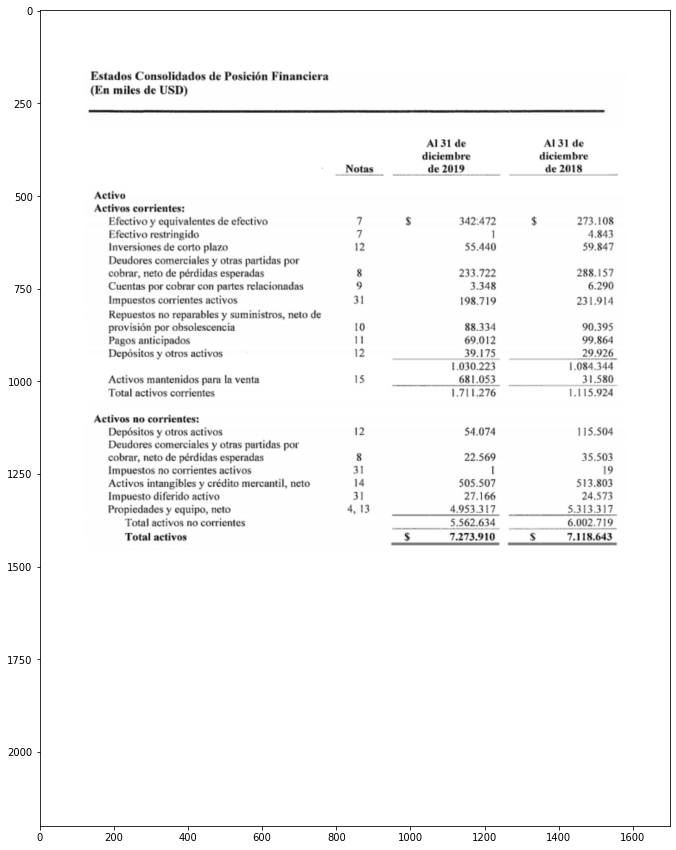

In [11]:
plot_image(cv2.imread(file_path))

### AWS Textract - Analyze document

In [12]:
def get_relationship_type_ids(ids, relationships):
    relationships_type = []
    relationships_ids = []
    for relationship in relationships:
        try:
            relationship = relationship[0]
            relationships_type.append(relationship['Type'])
            relationships_ids.append(
                [ids[ids == id_].index[0] for id_ in relationship['Ids']]
            )            
        except:
            relationships_type.append(None)
            relationships_ids.append(None)
    return relationships_type, relationships_ids

In [13]:
def get_father_ids(children_ids):
    father_id = [[] for index in range(len(children_ids))]
    for index, relationship_ids in enumerate(children_ids):
        if isinstance(relationship_ids, list):
            [father_id[id_].append(index) for id_ in relationship_ids]
    return father_id

In [14]:
def get_blocktypes_indexes(blocktype_serie, blocktypes):
    return [index for index, block in enumerate(blocktype_serie) if block in blocktypes]

In [15]:
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/textract.html#Textract.Client.analyze_document

# AWS Textract request
client_textract = boto3.client('textract')
analyze_document_original = pd.DataFrame(
    client_textract.analyze_document(
        Document={'Bytes': convert_img_to_bytes(file_path)},
        FeatureTypes=['TABLES'],
    )['Blocks']
)

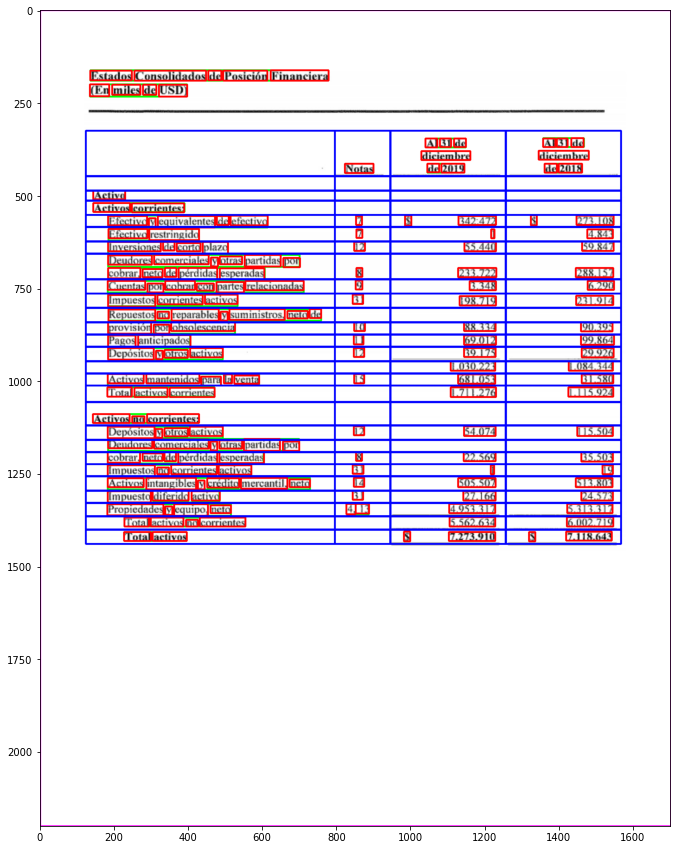

In [16]:
analyze_document = analyze_document_original.copy()

# Requested output
output_columns = [
    'Fecha', 
    'Unidades en las que se mide', 
    'Caja y bancos', 
    'Total activos', 
    'Total patrimonio', 
    'Ventas', 
    'Costo de ventas', 
    'Utilidad barata', 
    'Utilidad operacional', 
    'Utilidad antes de impuestos', 
    'Utilidad neta', 
]

# Data cleaning
analyze_document['Relationship_type'], analyze_document['Relationship_ids'] = get_relationship_type_ids(
    analyze_document['Id'], analyze_document['Relationships']
)
analyze_document.drop('Relationships', axis=1, inplace=True)

analyze_document['Father_id'] = get_father_ids(analyze_document['Relationship_ids'])

analyze_document['Bounding_box'] = analyze_document['Geometry'].map(lambda x: tuple(x['BoundingBox'].values()))
analyze_document.drop('Geometry', axis=1, inplace=True)

analyze_document['Text'] = analyze_document['Text'].fillna('')

# Plot image and bounding boxes
plot_image_bounding_boxes(file_path, analyze_document['Bounding_box'], list(analyze_document['BlockType']))

In [17]:
# Get line and word block type rows indexes
block_line_word_index = get_blocktypes_indexes(analyze_document['BlockType'], ['LINE', 'WORD'])
line_word_bounding_boxes = analyze_document['Bounding_box'].iloc[block_line_word_index]

# Get table block type rows indexes
block_table_index = get_blocktypes_indexes(analyze_document['BlockType'], ['TABLE'])
table_bounding_boxes = analyze_document['Bounding_box'].iloc[block_table_index]

In [18]:
def get_table_values(plot=False):
    table_cells = analyze_document[
        ['BlockType', 'Text', 'RowIndex', 'ColumnIndex', 'Relationship_ids', 'Father_id', 'Bounding_box']
    ]
    table_cells = table_cells[table_cells['BlockType'] == 'CELL']
    table_cells['Father_id'] = table_cells['Father_id'].map(lambda x: x[0])

    cell_text = []
    for cell_children in table_cells['Relationship_ids']:
        cell_text.append(
            ' '.join(list(analyze_document['Text'].iloc[cell_children].values)) 
            if cell_children is not None else None
        )
    table_cells['Text'] = cell_text
    table_cells['Text'].fillna('', inplace=True)

    if(plot):
        plot_image_bounding_boxes(file_path, list(table_cells['Bounding_box']), text=list(table_cells['Text']))

    df_table = []
    for table_father in table_cells['Father_id'].unique():
        table_text = table_cells[table_cells['Father_id'] == table_father]
        for index, row in enumerate(table_text['RowIndex'].unique()):
            df_table.append(
                [table_father] + list(table_text[table_text['RowIndex'] == row]['Text'].values)
            )
    df_table = pd.DataFrame(df_table)

    null_columns = df_table.isnull().sum()
    null_columns = null_columns[null_columns == len(df_table)].index
    df_table.drop(null_columns, axis=1, inplace=True)

    return df_table

#### Get table values

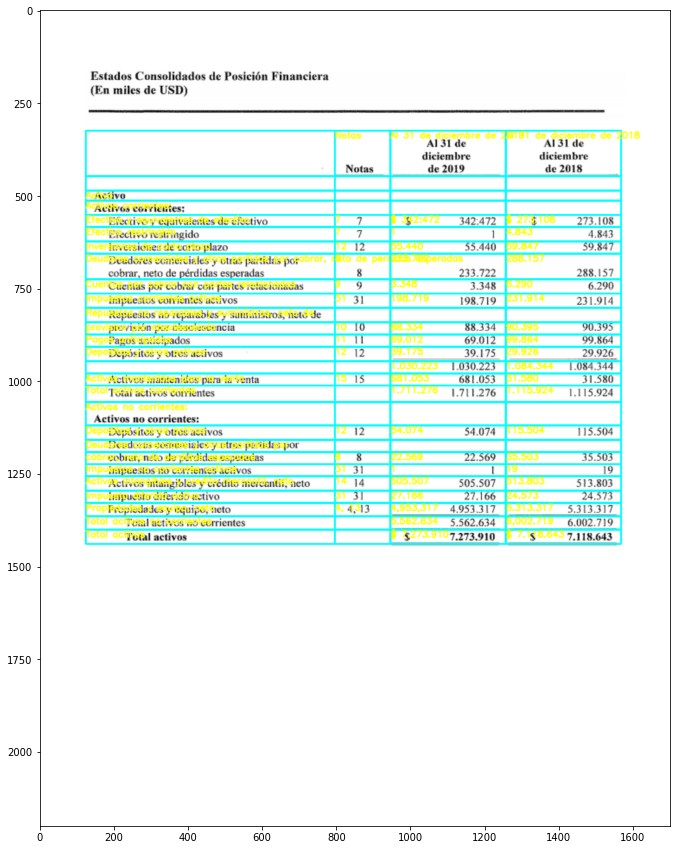

,0,1,2,3,4
0,277,,Notas,Al 31 de diciembre de 2019,AI 31 de diciembre de 2018
1,277,,,,
2,277,Activo,,,
3,277,Activos corrientes:,,,
4,277,Efectivo y equivalentes de efectivo,7,$ 342:472,$ 273.108
5,277,Efectivo restringido,7,1,4.843
6,277,Inversiones de corto plazo,12,55.440,59.847
7,277,Deudores comerciales y otras partidas por cobr...,8,233.722,288.157
8,277,Cuentas por cobrar con partes relacionadas,9,3.348,6.290
9,277,Impuestos corrientes activos,31,198.719,231.914


In [19]:
df_tables = None
if block_table_index != []:
    df_tables = get_table_values(plot=True)
df_tables

#### Get paragraph

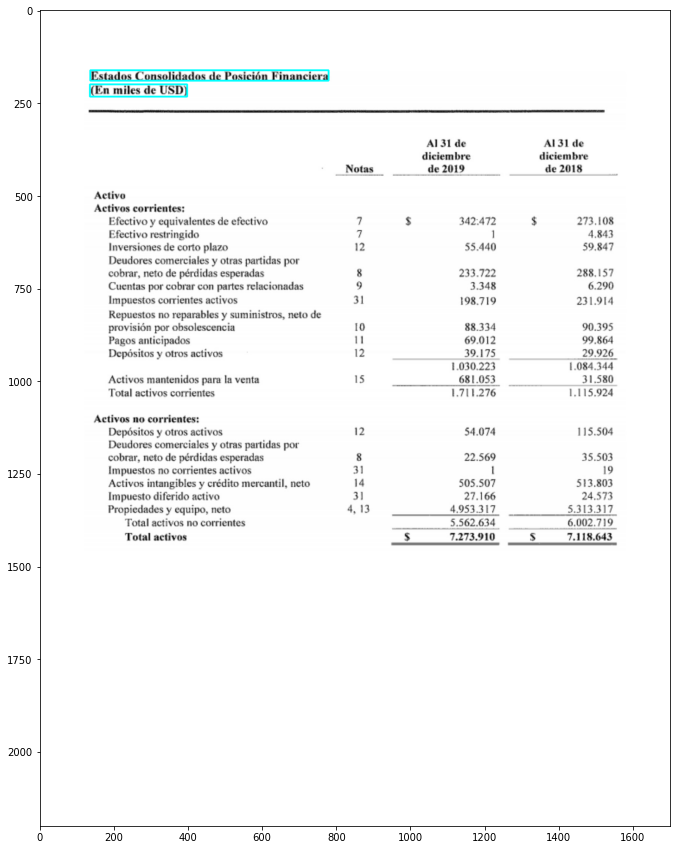

In [21]:
# Select line and word block type rows that do not belong to a table
paragraph_content = []
for table_bounding_box in table_bounding_boxes:
    paragraph_content.append(are_boxes_inside_box(list(line_word_bounding_boxes), table_bounding_box))
selected_paragraphs = paragraph_content[0]
for paragraph in paragraph_content[1:]:
    selected_paragraphs = [not(selected_paragraphs[idx] or paragraph[idx]) for idx in range(len(selected_paragraphs))]
if len(paragraph_content) == 1:
    selected_paragraphs = [not a for a in selected_paragraphs]

# Remove duplicate bounding boxes
text_indexes = line_word_bounding_boxes.iloc[selected_paragraphs].index
paragraph_content = analyze_document.iloc[text_indexes]
paragraph_content = analyze_document.iloc[paragraph_content.Father_id.map(lambda x: x[0] in paragraph_content.index).index]
paragraph_content = paragraph_content[['Text', 'Bounding_box']]
paragraph_content = paragraph_content.iloc[
    [not(is_box_inside_any_box(bounding_box, paragraph_content['Bounding_box'])) for bounding_box in paragraph_content['Bounding_box']]
]
paragraph_content.reset_index(drop=True, inplace=True)

plot_image_bounding_boxes(file_path, paragraph_content['Bounding_box'])

In [22]:
lines_idx = []
line = [paragraph_content['Bounding_box'][0]]
line_idx = [0]
x_coordinate = line[0][3]
tolerance = line[0][1] / 2.0
for index, bounding_box in enumerate(paragraph_content['Bounding_box'][1:]):
    if np.abs(x_coordinate - bounding_box[3]) < tolerance:
        line.append(bounding_box)
        line_idx.append(index+1)
    else:
        lines_idx.append(line_idx)
        line = [bounding_box]
        line_idx = [index+1]
        x_coordinate = line[0][3]
        tolerance = line[0][1] / 2.0
lines_idx.append(line_idx)

lines_text = []
for line_idx in lines_idx:
    lines_text.append([paragraph_content['Text'][idx] for idx in line_idx])
lines_text = pd.DataFrame(lines_text)
lines_text

,0
0,Estados Consolidados de Posicion Financiera
1,(En miles de USD)


In [20]:
def is_point_inside_box(point, box):
    if box[2] <= point[0] and point[0] <= box[2] + box[0]:
        if box[3] <= point[1] and point[1] <= box[3] + box[1]:
            return True 
    return False

def is_box_inside_box(small_box, big_box):
    points = [
        (small_box[2], small_box[3]), 
        (small_box[2] + small_box[0], small_box[3]), 
        (small_box[2]               , small_box[3] + small_box[1]), 
        (small_box[2] + small_box[0], small_box[3] + small_box[1])
    ]
    for point in points:
        if not is_point_inside_box(point, big_box):
            return False
    return True

def is_box_partially_inside_box(small_box, big_box):
    points = [
        (small_box[2], small_box[3]), 
        (small_box[2] + small_box[0], small_box[3]), 
        (small_box[2]               , small_box[3] + small_box[1]), 
        (small_box[2] + small_box[0], small_box[3] + small_box[1])
    ]
    for point in points:
        if is_point_inside_box(point, big_box):
            return True
    return False

def are_boxes_inside_box(boxes, big_box):
    return [is_box_inside_box(box, big_box) for box in boxes]

def are_boxes_complete_or_partially_inside_box(boxes, big_box):
    return [is_box_inside_box(box, big_box) or is_box_partially_inside_box(box, big_box) for box in boxes]

def is_box_inside_any_box(box, boxes):
    for box_ in boxes:
        if box == box_:
            continue
        if is_box_inside_box(box, box_):
            return True
    return False

### AWS Rekognition - DetectText

In [23]:
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html#Rekognition.Client.detect_text

'''
client_rekognition = boto3.client('rekognition', 'us-east-2')
detect_text = pd.DataFrame(
    client_rekognition.detect_text(
        Image={'Bytes': convert_img_to_bytes(file_path)}
    )['TextDetections']
)

img_bounding_boxes = cv2.imread(file_path)
for row in detect_text.itertuples():
    draw_bounding_box(
        img_bounding_boxes, 
        tuple(row.Geometry['BoundingBox'].values()), 
    )
'''

'''
plot_image(img_bounding_boxes)
detect_text[['DetectedText', 'Type', 'Confidence']].head()
'''

"\nplot_image(img_bounding_boxes)\ndetect_text[['DetectedText', 'Type', 'Confidence']].head()\n"

### AWS Textract - Detect document text

In [24]:
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/textract.html#Textract.Client.detect_document_text

'''
client_textract = boto3.client('textract')
detect_document_text = pd.DataFrame(
    client_textract.detect_document_text(
        Document={'Bytes': convert_img_to_bytes(file_path)},
    )['Blocks']
)
detect_document_text['Relationship_type'], detect_document_text['Relationship_ids'] = get_relationship_type_ids(detect_document_text['Id'], detect_document_text['Relationships'])
detect_document_text.drop('Relationships', axis=1, inplace=True)

img_bounding_boxes = cv2.imread(file_path)
for row in detect_document_text.itertuples():
    draw_bounding_box(
        img_bounding_boxes, 
        tuple(row.Geometry['BoundingBox'].values()), 
    )
'''

'''
plot_image(img_bounding_boxes)
detect_document_text[['BlockType', 'Confidence', 'Text', 'Relationship_ids']].head()
'''

"\nplot_image(img_bounding_boxes)\ndetect_document_text[['BlockType', 'Confidence', 'Text', 'Relationship_ids']].head()\n"

In [25]:
# Razonamiento geometrico